In [102]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from backup.module.preprocess import drop_columns

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'}) # 폰트 설정
plt.rc('font', family='AppleGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [78]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)
# 모든 컬럼 출력 설정
# pd.set_option('display.max_columns', None)
# 모든 행 출력 설정
# pd.set_option('display.max_rows', None)

import module

In [79]:
df, df_test_y = module.file_load.load_local_data()

In [80]:
df['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

is_test
0    1097155
1       5607
Name: count, dtype: int64

In [81]:
# 결측치가 많거나 필요 없는 컬럼을 정리한다
drop_columns = [
    '본번','부번','거래유형', '중개사소재지','등기신청일자',
       '해제사유발생일', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '단지신청일'
]

# 전처리

In [82]:
module.preprocess.컬럼_정리(df)
df_select = module.preprocess.drop_columns(df, drop_columns)
module.preprocess.번지_본번_부번_결측채우기(df_select)
df_select['평수'] = df_select['전용면적'] // 3.3
df_select['좌표X'].fillna(0, inplace=True)
df_select['좌표Y'].fillna(0, inplace=True)

In [83]:
df_select.drop(['평수'], axis=1, inplace=True)
df_select.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '좌표X',
       '좌표Y', 'target', 'is_test'],
      dtype='object')

# 파생변수

In [84]:
module.preprocess.시_군_구_add(df_select)
module.preprocess.강남_add(df_select)
module.preprocess.신축_add(df_select)
# module.preprocess.계약_건축년도_차이(df_select)

In [85]:
final_drop_columns = [
    '시','계약일'
]
df_select.drop(final_drop_columns, axis=1, inplace=True)

# Model Training

## 범주형 변수 Encoding

In [86]:
model_data = df_select.copy()

In [87]:
dt_train, dt_test = module.preprocess.split_train_test(model_data)
categorical_columns_v2 = module.preprocess.범주형_filter(dt_train)
label_encoders = module.preprocess.범주형_encoding(dt_train, dt_test, categorical_columns_v2)
print(dt_train.shape, dt_test.shape)

100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

(1097155, 13) (5607, 13)


## Model Training


# 훈련데이터 분할

In [88]:
X_train, X_val, y_train, y_val = module.preprocess.holdout_split_X_y(dt_train)

In [89]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((877724, 12), (219431, 12), (877724,), (219431,))

In [90]:
X_train.head(1)

,번지,아파트명,전용면적,계약년월,층,건축년도,도로명,좌표X,좌표Y,구,동,강남여부
586784,1444,3131,79.47,201605,11,1988,4922,0.0,0.0,14,151,1


In [91]:
# RandomForestRegressor 를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [92]:
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 6974.263713048701


In [93]:
X_test = dt_test.drop(['target'], axis=1)

real_test_pred = model.predict(X_test)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(df_test_y, real_test_pred))}')

RMSE test: 29225.73434600833


In [94]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

In [95]:
X_val = X_test
X_val['target'] = df_test_y
X_val['pred'] = real_test_pred
X_val['예측차이'] = X_val['target'] - X_val['pred']
# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [96]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [97]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [98]:
X_val_sort_top100.to_csv('top100_top_전용면적안함.csv', index=False)
X_val_sort_tail100.to_csv('tail100_error_전용면적안함.csv', index=False)

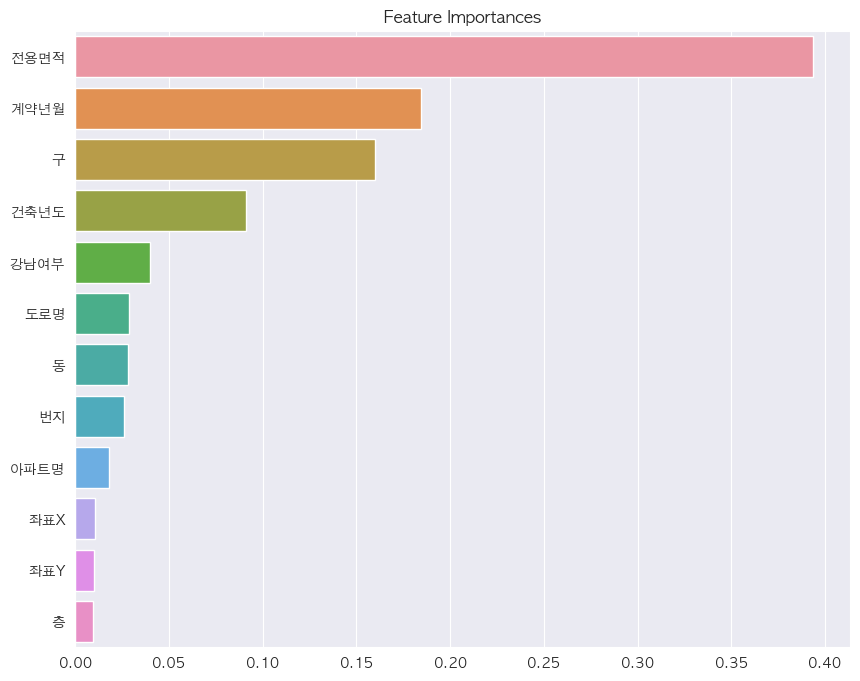

In [99]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

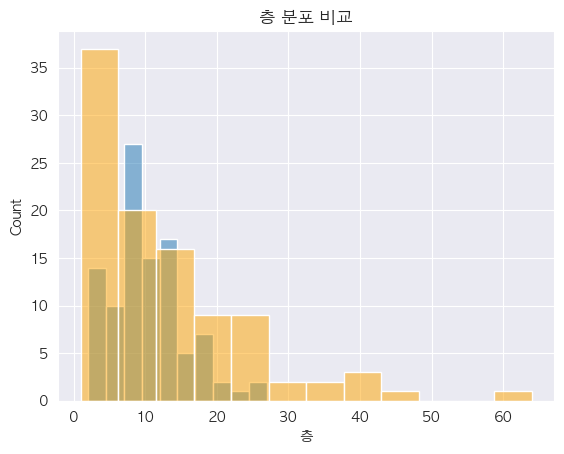

In [103]:
sns.histplot(data = X_val_sort_tail100, x='층', alpha=0.5)
sns.histplot(data = X_val_sort_top100, x='층', color='orange', alpha=0.5)
plt.title('층 분포 비교')
plt.show()

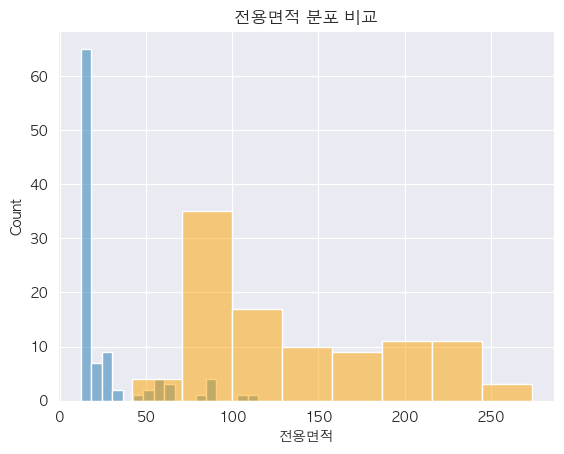

In [104]:
sns.histplot(data = X_val_sort_tail100, x='전용면적', alpha=0.5)
sns.histplot(data = X_val_sort_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

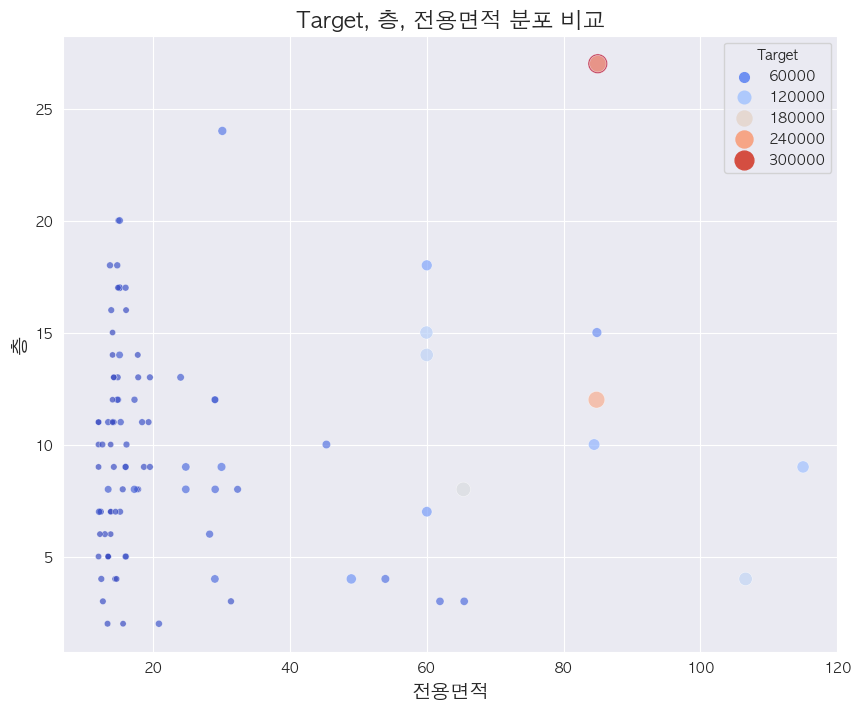

In [107]:

# 2D 히트맵으로 target, 층, 전용면적의 분포 비교
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=X_val_sort_tail100, 
    x='전용면적', 
    y='층', 
    size='target', 
    hue='target', 
    palette='coolwarm', 
    alpha=0.7, 
    sizes=(20, 200)
)
plt.title('Target, 층, 전용면적 분포 비교', fontsize=16)
plt.xlabel('전용면적', fontsize=14)
plt.ylabel('층', fontsize=14)
plt.legend(title='Target')
plt.grid(True)
plt.show()